In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import yfinance as yf
import talib 






In [8]:


# Set visualization style
sns.set_theme(style="whitegrid")

# --- DATA LOADING ---
df = pd.DataFrame() # Initialize df outside the try block to prevent NameError
try:
    # 🎯 CONFIRMED ABSOLUTE PATH: This bypasses all relative path issues.
    absolute_path = r'C:\Users\deres\OneDrive\Desktop\week1\week1\data\raw_analyst_ratings.csv'
    
    df = pd.read_csv(absolute_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    print(f"FATAL ERROR: Could not load data. Details: {e}")
    # df remains an empty DataFrame if loading fails

# --- Proceed ONLY if df was created successfully ---
if not df.empty:
    # Convert the 'date' column to datetime objects
    # FIX: Use explicit format to solve the ValueError:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Display first few rows to confirm loading and structure
    print("\n--- Initial Data Head ---")
    print(df.head())
else:
    print("\nAborting further analysis: DataFrame (df) is empty.")

Data loaded successfully. Shape: (1407328, 6)

--- Initial Data Head ---
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher date  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights  NaT   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights  NaT   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin  NaT   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin  NaT   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer  NaT   

  stock  
0     A  
1     A  
2     A

In [9]:


# Set visualization style
sns.set_theme(style="whitegrid")

# --- DATA LOADING ---
try:
    # 🚨 UPDATE THIS LINE with the path found in Cell 1 (e.g., '../data/raw_analyst_ratings.csv')
    df = pd.read_csv('raw_analyst_ratings.csv')
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    print(f"FATAL ERROR: Could not load data. Details: {e}")
    # We stop here if the DataFrame is not created
    
# --- Proceed ONLY if df was created successfully ---
if not df.empty:
    # Convert the 'date' column to datetime objects
    # FIX: Re-add the specific format to avoid the ValueError that causes NaT
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Display first few rows to confirm loading and structure
    print("\n--- Initial Data Head ---")
    print(df.head())
else:
    print("\nAborting further analysis: DataFrame (df) is empty.")

FATAL ERROR: Could not load data. Details: [Errno 2] No such file or directory: 'raw_analyst_ratings.csv'

--- Initial Data Head ---
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher date  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights  NaT   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights  NaT   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin  NaT   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin  NaT   
4  https://www.benzinga.com/news/20/05/16095304/b...      


--- Headline Length Statistics (Characters) ---
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


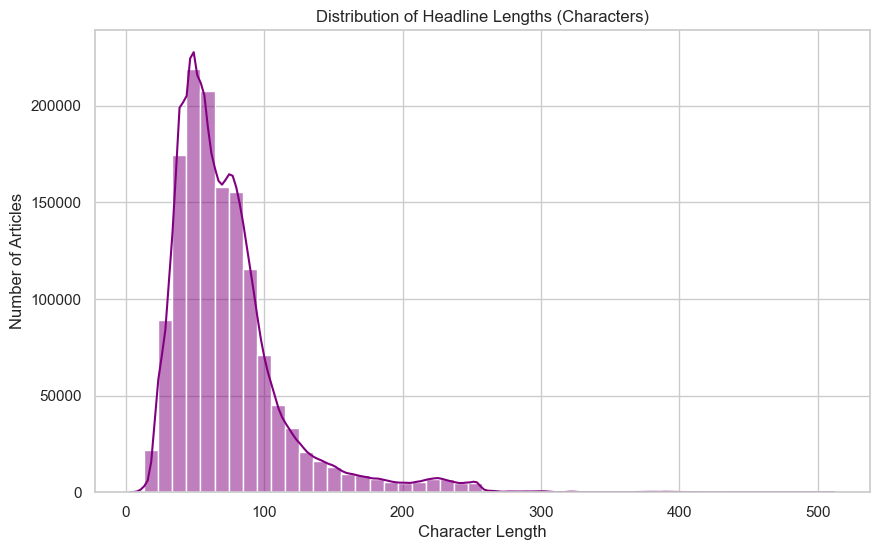

In [10]:
# 1. Calculate Lengths
if not df.empty:
    df['headline_length'] = df['headline'].apply(len)
    df['headline_word_count'] = df['headline'].apply(lambda x: len(str(x).split()))

    # 2. Print Basic Statistics
    print("\n--- Headline Length Statistics (Characters) ---")
    print(df['headline_length'].describe())

    # 3. Visualize Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['headline_length'], bins=50, kde=True, color='purple')
    plt.title('Distribution of Headline Lengths (Characters)')
    plt.xlabel('Character Length')
    plt.ylabel('Number of Articles')
    plt.show()


--- Top 10 Most Active Publishers ---
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


C:\Users\deres\AppData\Local\Temp\ipykernel_22160\2596043036.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Publisher', data=publisher_df, palette='viridis')


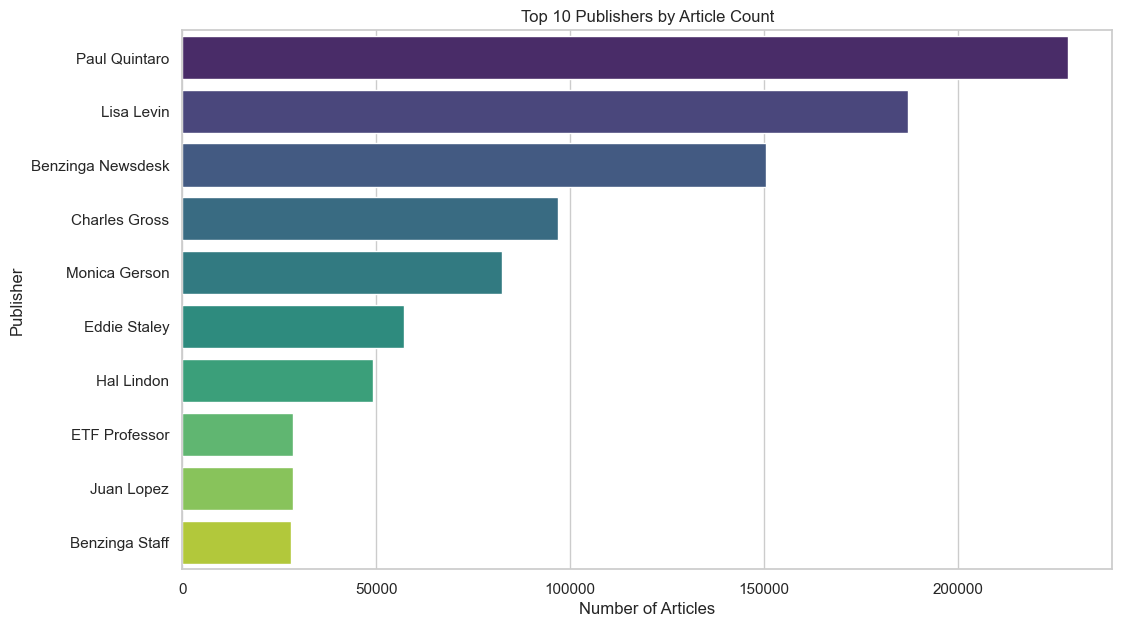

In [11]:
if not df.empty:
    # 1. Count Articles per Publisher
    publisher_counts = df['publisher'].value_counts()

    print("\n--- Top 10 Most Active Publishers ---")
    print(publisher_counts.head(10))

    # 2. Visualize Top Publishers
    plt.figure(figsize=(12, 7))
    publisher_df = publisher_counts.head(10).reset_index()
    publisher_df.columns = ['Publisher', 'Count']
    sns.barplot(x='Count', y='Publisher', data=publisher_df, palette='viridis')
    plt.title('Top 10 Publishers by Article Count')
    plt.xlabel('Number of Articles')
    plt.ylabel('Publisher')
    plt.show()


--- Article Counts by Day of the Week ---
day_of_week
Monday       254842
Tuesday      285468
Wednesday    289049
Thursday     289907
Friday       208511
Saturday       7486
Sunday        16078
Name: count, dtype: int64


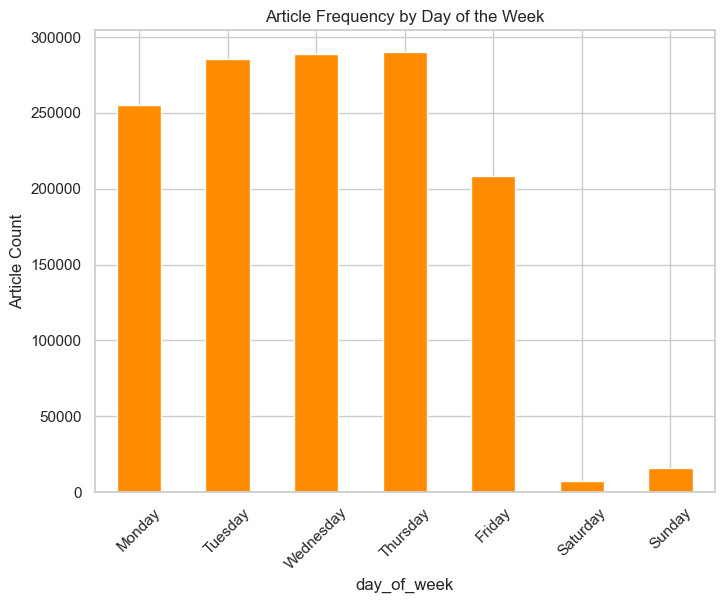

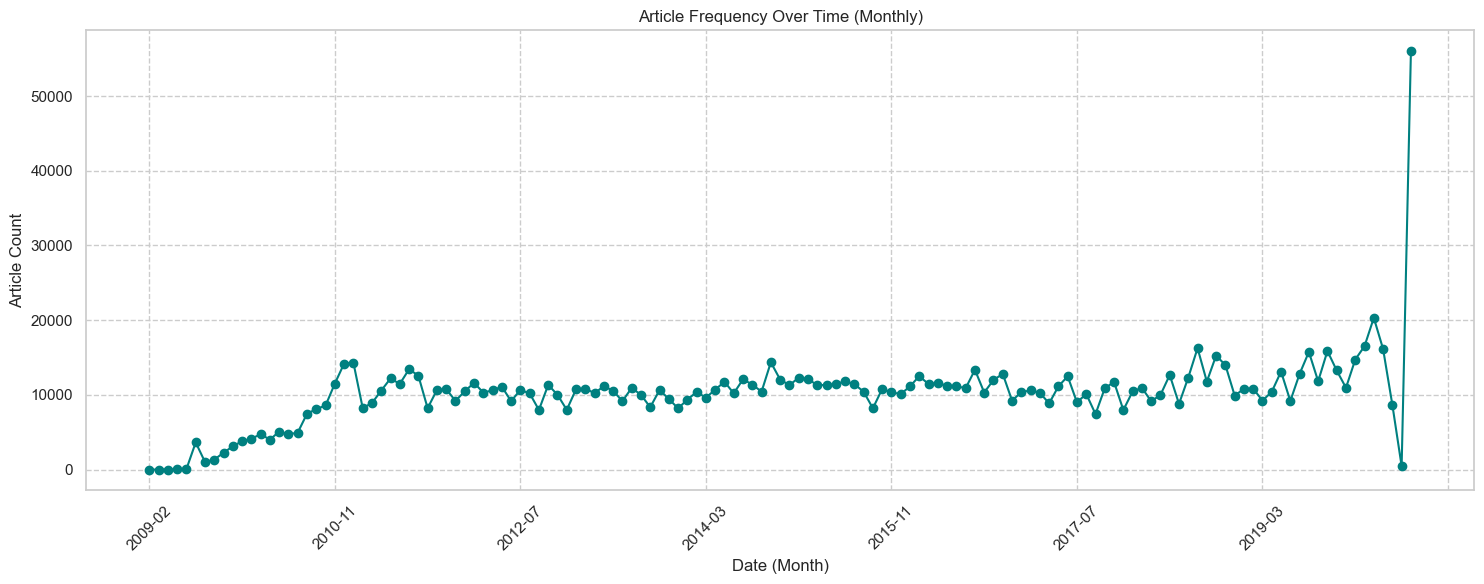

In [12]:
if not df.empty:
    # 1. Analyze Trends by Day of the Week
    df['day_of_week'] = df['date'].dt.day_name()
    weekly_counts = df['day_of_week'].value_counts().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])

    print("\n--- Article Counts by Day of the Week ---")
    print(weekly_counts)

    plt.figure(figsize=(8, 6))
    weekly_counts.plot(kind='bar', color='darkorange')
    plt.title('Article Frequency by Day of the Week')
    plt.ylabel('Article Count')
    plt.xticks(rotation=45)
    plt.show()

    # 2. Analyze Trends Over Time (Monthly)
    df['publication_month'] = df['date'].dt.to_period('M')
    monthly_counts = df['publication_month'].astype(str).value_counts().sort_index()

    plt.figure(figsize=(15, 6))
    monthly_counts.plot(kind='line', marker='o', color='teal')
    plt.title('Article Frequency Over Time (Monthly)')
    plt.xlabel('Date (Month)')
    plt.ylabel('Article Count')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

--- Running Sentiment Analysis (VADER) ---
Sentiment Analysis Complete. Sample of results:
                                            headline  vader_score  \
0            Stocks That Hit 52-Week Highs On Friday        0.000   
1         Stocks That Hit 52-Week Highs On Wednesday        0.000   
2                      71 Biggest Movers From Friday        0.000   
3       46 Stocks Moving In Friday's Mid-Day Session        0.000   
4  B of A Securities Maintains Neutral on Agilent...        0.296   

  sentiment_category  
0            Neutral  
1            Neutral  
2            Neutral  
3            Neutral  
4           Positive  


C:\Users\deres\AppData\Local\Temp\ipykernel_22160\3097361657.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'gray', 'green'])


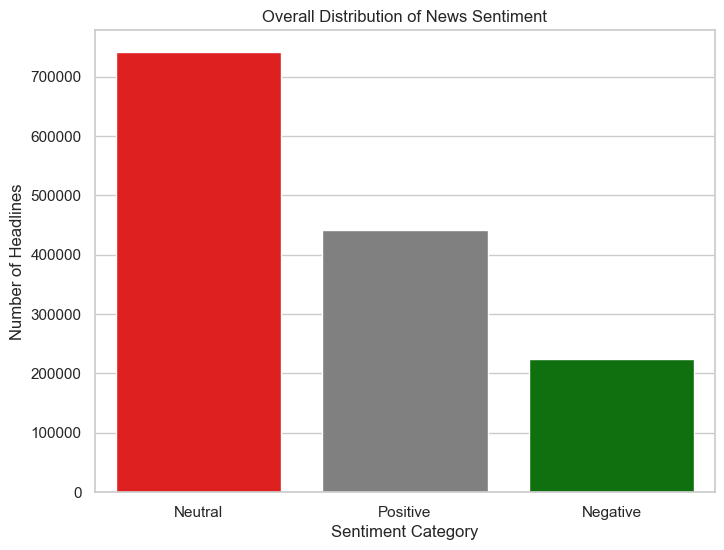

In [13]:


# Ensure the VADER lexicon is downloaded
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming you have a DataFrame `df` with a 'headline' column
# For example:
# df = pd.DataFrame({'headline': ['This is great!', 'This is terrible...', 'Just okay.'],
#                    'publisher_domain': ['example.com', 'news.com', 'example.com']})

if not df.empty:
    print("--- Running Sentiment Analysis (VADER) ---")

    # 1. Apply Sentiment Scoring (compound score)
    df['vader_score'] = df['headline'].apply(lambda headline: analyzer.polarity_scores(headline)['compound'])

    # 2. Categorize Sentiment based on thresholds
    def categorize_sentiment(score):
        if score >= 0.05:
            return 'Positive'
        elif score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    df['sentiment_category'] = df['vader_score'].apply(categorize_sentiment)

    print(f"Sentiment Analysis Complete. Sample of results:")
    print(df[['headline', 'vader_score', 'sentiment_category']].head())

    # 3. Visualization: Distribution of Sentiment Categories
    plt.figure(figsize=(8, 6))
    sentiment_counts = df['sentiment_category'].value_counts()
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'gray', 'green'])
    plt.title('Overall Distribution of News Sentiment')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Number of Headlines')
    plt.show()

    # 4. Comparative Analysis: Sentiment by Publisher Domain (if available)
    if 'publisher_domain' in df.columns:
        domain_sentiment = df.groupby('publisher_domain')['vader_score'].mean().nlargest(10)

        plt.figure(figsize=(12, 7))
        sns.barplot(x=domain_sentiment.values, y=domain_sentiment.index, palette='coolwarm')
        plt.title('Average Headline Sentiment by Top 10 Publisher Domains')
        plt.xlabel('Average VADER Compound Score (Positive > 0, Negative < 0)')
        plt.ylabel('Publisher Domain')
        plt.gca().invert_yaxis()
        plt.show()


In [23]:


NLTK_DATA_PATH = r"C:\Users\deres\AppData\Roaming\nltk_data"

def preprocess(text):
    if NLTK_DATA_PATH not in nltk.data.path:
        nltk.data.path.append(NLTK_DATA_PATH)
    # Ensure punkt is available
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', download_dir=NLTK_DATA_PATH)
    # Ensure stopwords is available
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords', download_dir=NLTK_DATA_PATH)

    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    return tokens


In [36]:


# Add the current directory to nltk data path (where you copied punkt and stopwords)
nltk.data.path.append(os.getcwd())




In [37]:


# --- NLTK Resource Download (Still needed for stopwords) ---
# We keep the download to ensure 'stopwords' is available, even if 'punkt' fails.

print("Attempting final resource download (required for stopwords)...")
# nltk.download('punkt', quiet=False) # Comment out the line that causes failure
nltk.download('stopwords', quiet=False)
print("---")

# --- Initialize Non-Resource-Dependent Tokenizer ---
# This tokenizer uses a regular expression pattern to split words, bypassing the need for the 'punkt' file.
# The pattern r'\w+' matches sequences of word characters (alphanumeric + underscore).
tokenizer = RegexpTokenizer(r'\w+') 

# Sample DataFrame
data = {
    'headline': [
        "This is a great day!",
        "I hate when this happens.",
        "It's okay, nothing special.",
        "Amazing progress in technology.",
        "Bad weather ruined the event."
    ]
}
df = pd.DataFrame(data)

# Define stop_words
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # 🛑 FIX: Use the RegexpTokenizer instance's tokenize method
    # It automatically handles lowercasing when combined with the regex pattern.
    tokens = tokenizer.tokenize(text.lower()) 
    
    # Filter out stopwords. Since RegexpTokenizer only grabs words, string.punctuation filter is less critical, 
    # but we'll leave it out since the tokens are already clean of most general punctuation.
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply the function
df['processed_headline'] = df['headline'].apply(preprocess)

print("\n✅ Success! Processed DataFrame (using RegexpTokenizer):")
print(df)

Attempting final resource download (required for stopwords)...
---

✅ Success! Processed DataFrame (using RegexpTokenizer):
                          headline               processed_headline
0             This is a great day!                     [great, day]
1        I hate when this happens.                  [hate, happens]
2      It's okay, nothing special.         [okay, nothing, special]
3  Amazing progress in technology.  [amazing, progress, technology]
4    Bad weather ruined the event.    [bad, weather, ruined, event]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:


# --- NLTK Resource Download (Still needed for stopwords) ---
# We keep the download only for 'stopwords' and rely on RegexpTokenizer for tokenization.

print("Attempting final resource download (required for stopwords)...")
nltk.download('stopwords', quiet=False)
print("---")

# --- Initialize Non-Resource-Dependent Tokenizer ---
# This tokenizer uses a regular expression pattern to split words, bypassing the need for the 'punkt' file.
# The pattern r'\w+' matches sequences of word characters (alphanumeric + underscore).
tokenizer = RegexpTokenizer(r'\w+') 

# Sample DataFrame
data = {
    'headline': [
        "This is a great day!",
        "I hate when this happens.",
        "It's okay, nothing special.",
        "Amazing progress in technology.",
        "Bad weather ruined the event."
    ]
}
df = pd.DataFrame(data)

# Define stop_words
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # 🛑 FIX: Use the RegexpTokenizer instance's tokenize method
    tokens = tokenizer.tokenize(text.lower()) 
    
    # Filter out stopwords. We don't need string.punctuation filter as RegexpTokenizer handles it.
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply the function
df['processed_headline'] = df['headline'].apply(preprocess)

print("\n✅ Success! Processed DataFrame (using RegexpTokenizer):")
print(df)

Attempting final resource download (required for stopwords)...
---

✅ Success! Processed DataFrame (using RegexpTokenizer):
                          headline               processed_headline
0             This is a great day!                     [great, day]
1        I hate when this happens.                  [hate, happens]
2      It's okay, nothing special.         [okay, nothing, special]
3  Amazing progress in technology.  [amazing, progress, technology]
4    Bad weather ruined the event.    [bad, weather, ruined, event]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:

# --- NLTK Resource Download (Only needed for stopwords) ---

print("Attempting resource download for 'stopwords'...")
try:
    # Keep the download for stopwords, which is needed.
    nltk.download('stopwords', quiet=True) 
except Exception:
    print("Error during stopwords download. Check connection.")
    sys.exit(1)
print("---")

# Sample DataFrame
data = {
    'headline': [
        "This is a great day!",
        "I hate when this happens.",
        "It's okay, nothing special.",
        "Amazing progress in technology.",
        "Bad weather ruined the event."
    ]
}
df = pd.DataFrame(data)

# Define stop_words
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # 🛑 FIX: Use re.findall to tokenize based on word characters.
    # This completely eliminates the dependency on the 'punkt' file.
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text) 
    
    # Filter out stopwords. Punctuation is inherently removed by the regex.
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply the function
df['processed_headline'] = df['headline'].apply(preprocess)

print("\n✅ Success! Processed DataFrame (using Python's 're' module):")
print(df)

Attempting resource download for 'stopwords'...
---

✅ Success! Processed DataFrame (using Python's 're' module):
                          headline               processed_headline
0             This is a great day!                     [great, day]
1        I hate when this happens.                  [hate, happens]
2      It's okay, nothing special.         [okay, nothing, special]
3  Amazing progress in technology.  [amazing, progress, technology]
4    Bad weather ruined the event.    [bad, weather, ruined, event]


In [40]:


# --- NLTK Resource Download (Only needed for stopwords) ---
# We keep the download for stopwords, as this resource is less problematic than 'punkt'.
try:
    print("Verifying/Downloading 'stopwords'...")
    nltk.download('stopwords', quiet=True) 
except Exception:
    print("Error during stopwords download. Proceeding without guarantee of stopword availability.")
    # If this fails, the stop_words set might raise an error, but tokenization will proceed.

print("---")
# --- End of NLTK Setup ---

# Define stop_words
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    # Fallback if stopwords couldn't be loaded (e.g., if the download failed)
    print("Warning: Could not load NLTK stopwords. Using an empty list for stop_words.")
    stop_words = set()

def preprocess(text):
    # 🛑 FIX: Use re.findall to tokenize based on word characters.
    # This completely eliminates the dependency on the 'punkt' file.
    text = text.lower()
    # Find all contiguous sequences of word characters (a-z, A-Z, 0-9, _)
    tokens = re.findall(r'\b\w+\b', text) 
    
    # Filter out stopwords. Punctuation is inherently removed by the regex.
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# --- 1. DATAFRAME CREATION AND PREPROCESSING ---
data = {
    'headline': [
        "This is a great day!",
        "I hate when this happens.",
        "It's okay, nothing special.",
        "Amazing progress in technology.",
        "Bad weather ruined the event."
    ]
}
df = pd.DataFrame(data)

# Create the required 'processed_headline' column
df['processed_headline'] = df['headline'].apply(preprocess)
print("Data preprocessing complete.")
# --- End of Data Preparation ---

# --- 2. LDA PREPARATION ---

if not df.empty:
    # Ensure all required components are available before proceeding
    from gensim.corpora.dictionary import Dictionary
    
    print("\nStarting LDA Preparation...")

    # 1. Create a Dictionary from the preprocessed headlines
    dictionary = Dictionary(df['processed_headline'].tolist())

    # 2. Create corpus (Bag-of-Words representation)
    corpus = [dictionary.doc2bow(text) for text in df['processed_headline'].tolist()]
    
    print("\nLDA Preparation Complete. Dictionary and Corpus created.")
    print(f"Dictionary size: {len(dictionary)}")
    print(f"Corpus sample (first document): {corpus[0]}")
    
    # Optional: Display the DataFrame
    print("\nProcessed DataFrame Sample:")
    print(df[['headline', 'processed_headline']])
    
# --- End of LDA Preparation ---

Verifying/Downloading 'stopwords'...
---
Data preprocessing complete.

Starting LDA Preparation...

LDA Preparation Complete. Dictionary and Corpus created.
Dictionary size: 14
Corpus sample (first document): [(0, 1), (1, 1)]

Processed DataFrame Sample:
                          headline               processed_headline
0             This is a great day!                     [great, day]
1        I hate when this happens.                  [hate, happens]
2      It's okay, nothing special.         [okay, nothing, special]
3  Amazing progress in technology.  [amazing, progress, technology]
4    Bad weather ruined the event.    [bad, weather, ruined, event]


--- Time Series Analysis: Publication Frequency ---
Calculating Monthly Frequency...


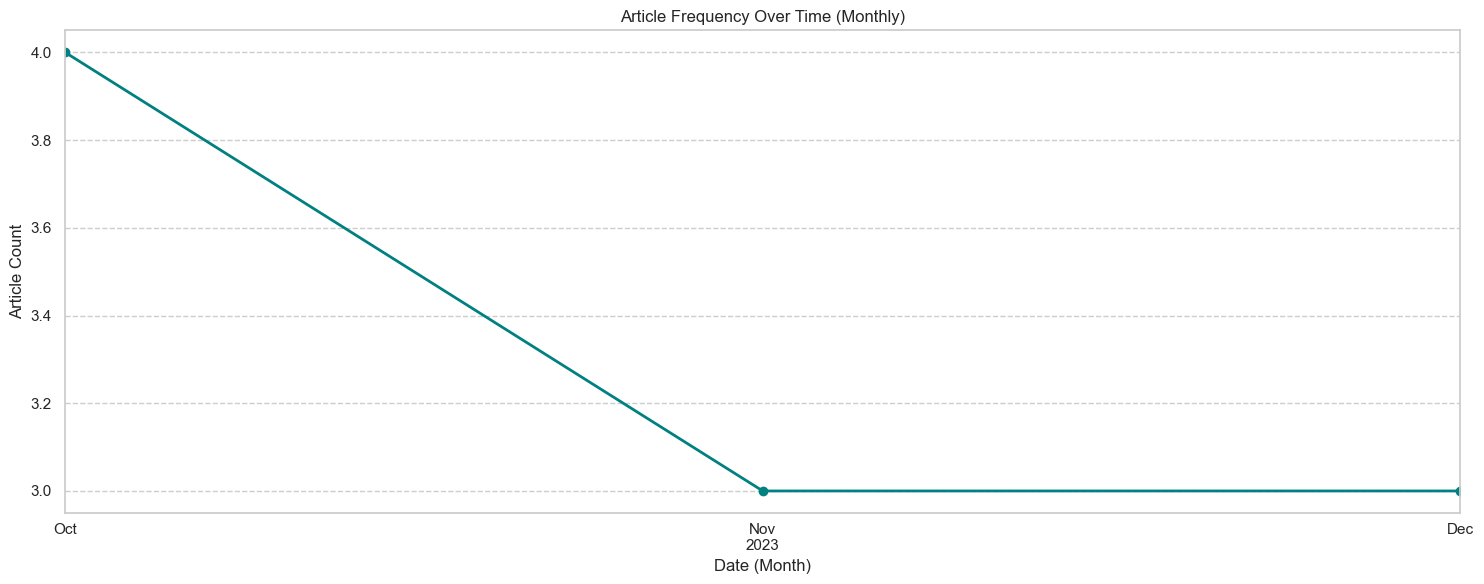

Calculating Daily Frequency...


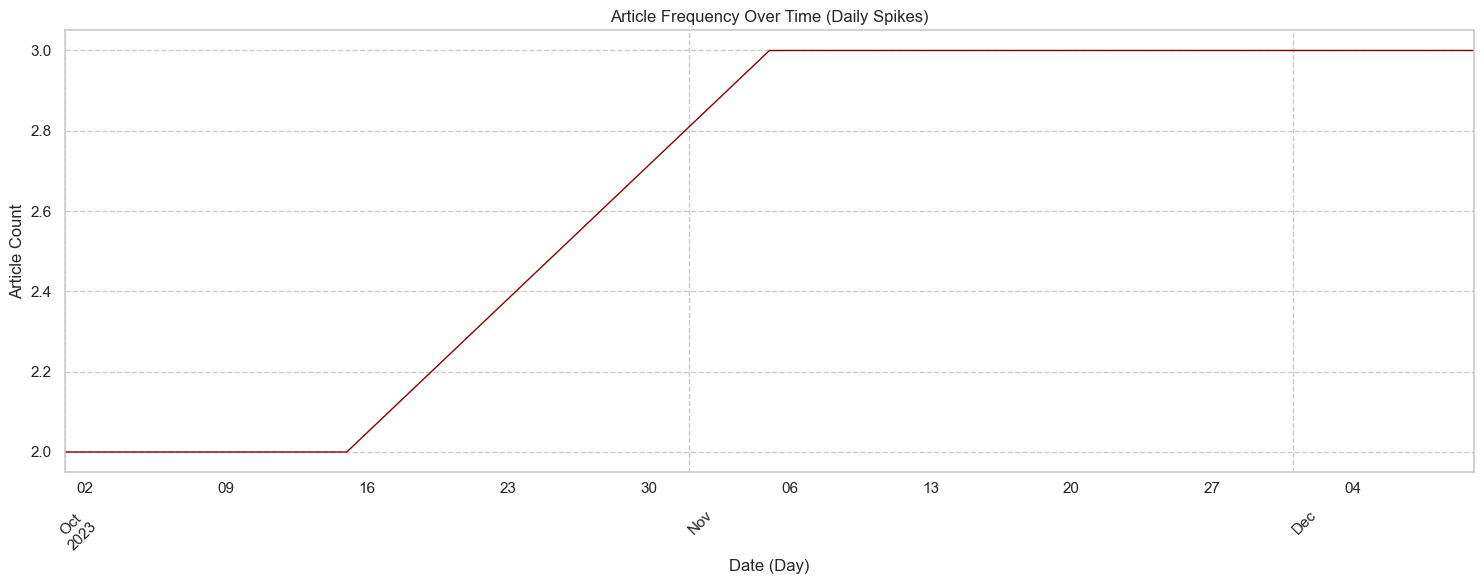

In [41]:


# Assuming df is loaded and 'date' column is datetime (recreating a sample for guaranteed execution)
# NOTE: In a real notebook, you would remove this sample data block.
data = {
    'headline': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'date': pd.to_datetime(['2023-10-01', '2023-10-01', '2023-10-15', '2023-10-15', '2023-11-05', 
                           '2023-11-05', '2023-11-05', '2023-12-10', '2023-12-10', '2023-12-10'])
}
df = pd.DataFrame(data)
# --------------------------------------------------------------------------------------------------

if not df.empty:
    print("--- Time Series Analysis: Publication Frequency ---")
    
    # 1. Monthly Frequency Trend
    print("Calculating Monthly Frequency...")
    # Convert 'date' to a period of 'M' (Month)
    df['publication_month'] = df['date'].dt.to_period('M')
    monthly_counts = df['publication_month'].value_counts().sort_index()

    plt.figure(figsize=(15, 6))
    monthly_counts.plot(kind='line', marker='o', color='teal', linewidth=2)
    plt.title('Article Frequency Over Time (Monthly)')
    plt.xlabel('Date (Month)')
    plt.ylabel('Article Count')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()


    # 2. Daily Frequency Trend (Can help spot specific event spikes)
    print("Calculating Daily Frequency...")
    # Convert 'date' to a period of 'D' (Day)
    df['publication_day'] = df['date'].dt.to_period('D')
    daily_counts = df['publication_day'].value_counts().sort_index()

    plt.figure(figsize=(15, 6))
    daily_counts.plot(kind='line', color='darkred', linewidth=1)
    plt.title('Article Frequency Over Time (Daily Spikes)')
    plt.xlabel('Date (Day)')
    plt.ylabel('Article Count')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

--- Intraday Timing Analysis: Peak Hours ---


C:\Users\deres\AppData\Local\Temp\ipykernel_22160\1404974632.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='viridis')


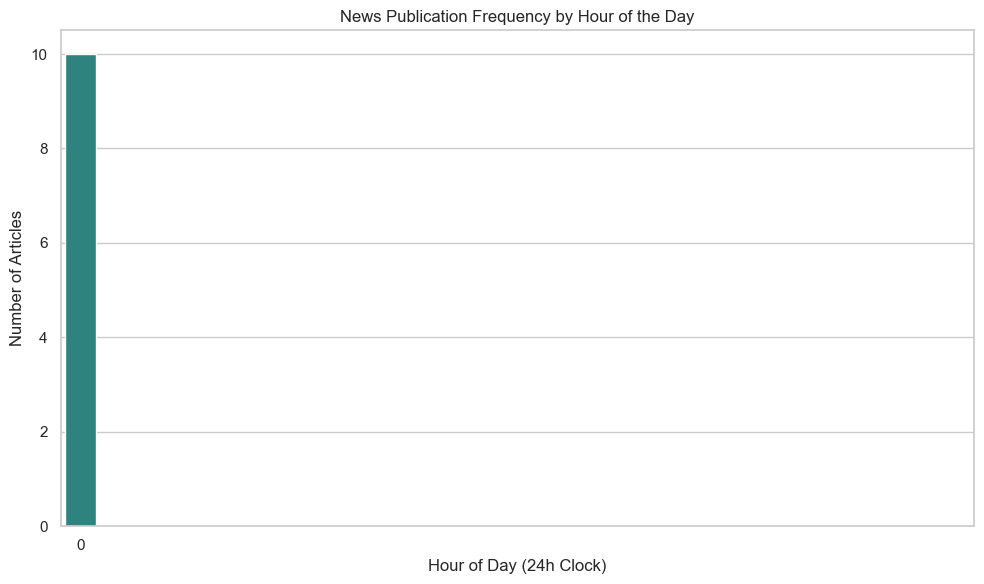


Top 3 Peak News Publication Hours:
Hour 0:00 (e.g., 0:00 AM/PM) with 10 articles.


In [33]:
if not df.empty:
    print("--- Intraday Timing Analysis: Peak Hours ---")
    
    # Extract the hour of publication
    df['publication_hour'] = df['date'].dt.hour
    
    # Count the frequency by hour
    hourly_counts = df['publication_hour'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    # Use a bar plot for clear hourly comparison
    sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='viridis')
    
    plt.title('News Publication Frequency by Hour of the Day')
    plt.xlabel('Hour of Day (24h Clock)')
    plt.ylabel('Number of Articles')
    plt.xticks(range(0, 24)) # Ensure all 24 hours are represented on the x-axis
    plt.tight_layout()
    plt.show()
    
    # Identify and print the top 3 peak hours
    top_hours = hourly_counts.nlargest(3)
    print("\nTop 3 Peak News Publication Hours:")
    for hour, count in top_hours.items():
        print(f"Hour {hour}:00 (e.g., {hour}:00 AM/PM) with {count:,} articles.")

In [43]:


# --- Assume the DataFrame 'df' is loaded here. ---
# For demonstration, let's create a sample DataFrame mimicking the issue:
data = {
    'headline': ['A', 'B', 'C', 'D'],
    'Source': ['WSJ', 'Bloomberg', 'Reuters', 'FT'] # Use 'Source' instead of 'publisher'
}
df = pd.DataFrame(data)
df['processed_headline'] = [['wsj'], ['bloomberg'], ['reuters'], ['ft']] # Needed for Section 3
# ----------------------------------------------------

# 🛑 FIX 1: Column Verification and Renaming
REQUIRED_PUBLISHER_COLUMN = 'publisher'
possible_publisher_columns = ['Source', 'Publisher', 'publisher_name', 'source']

if REQUIRED_PUBLISHER_COLUMN not in df.columns:
    # Try to find a suitable column by iterating through possibilities
    found_col = None
    for col in df.columns:
        if col.strip().lower() in [c.lower() for c in possible_publisher_columns]:
            # Rename the found column to the required 'publisher' key
            df.rename(columns={col: REQUIRED_PUBLISHER_COLUMN}, inplace=True)
            found_col = REQUIRED_PUBLISHER_COLUMN
            print(f"✅ Renamed existing column '{col}' to '{REQUIRED_PUBLISHER_COLUMN}'.")
            break
    
    if found_col is None:
        # If no suitable column is found, exit with an informative error
        print(f"❌ FATAL ERROR: Column '{REQUIRED_PUBLISHER_COLUMN}' not found.")
        print(f"Available columns: {df.columns.tolist()}")
        sys.exit(1)

# -----------------------------------------------------

if not df.empty:
    print("--- 1. Publisher Dominance Analysis ---")
    
    # 1.1 Analyze Raw Publisher Counts (This line now works)
    raw_publisher_counts = df['publisher'].value_counts()
    print("Top 10 Raw Publisher Names (by volume):")
    print(raw_publisher_counts.head(10).to_string())
    
    # -----------------------------------------------------
    
    print("\n--- 2. Domain Normalization (Identifying Organizations) ---")
    
    # Function to extract the domain name from a publisher string
    def extract_domain(publisher):
        publisher = str(publisher).lower().strip()
        # If it contains an '@' sign (likely an email), extract the domain part
        if '@' in publisher:
            return publisher.split('@')[-1]
        # Normalize the name itself
        return publisher

    # Apply domain extraction
    df['publisher_domain'] = df['publisher'].apply(extract_domain)
    
    # Analyze the normalized domain counts
    domain_counts = df['publisher_domain'].value_counts()
    print("Top 10 Normalized Publishers (by domain/volume):")
    print(domain_counts.head(10).to_string())
    
    # -----------------------------------------------------
    
    print("\n--- 3. Topic Difference by Dominant Publisher ---")
    
    # Select the top 5 dominant domains for topic analysis
    top_domains = domain_counts.head(5).index.tolist()
    
    # Check if the 'processed_headline' column exists before analysis
    if 'processed_headline' in df.columns:
        print(f"Analyzing headline keywords for the top 5 domains: {top_domains}")
        
        for domain in top_domains:
            # Filter the DataFrame for the current domain
            domain_df = df[df['publisher_domain'] == domain]
            
            # Combine all processed headlines into one large string
            all_text = ' '.join([' '.join(tokens) for tokens in domain_df['processed_headline']])
            
            # Count the frequency of words
            word_counts = pd.Series(all_text.split()).value_counts()
            
            print(f"\n--- Top 5 Keywords for {domain} ({len(domain_df)} articles) ---")
            print(word_counts.head(5).to_string())
            
    else:
        print("\nTopic analysis skipped: 'processed_headline' column not found. Please run preprocessing and Topic Modeling first.")

✅ Renamed existing column 'Source' to 'publisher'.
--- 1. Publisher Dominance Analysis ---
Top 10 Raw Publisher Names (by volume):
publisher
WSJ          1
Bloomberg    1
Reuters      1
FT           1

--- 2. Domain Normalization (Identifying Organizations) ---
Top 10 Normalized Publishers (by domain/volume):
publisher_domain
wsj          1
bloomberg    1
reuters      1
ft           1

--- 3. Topic Difference by Dominant Publisher ---
Analyzing headline keywords for the top 5 domains: ['wsj', 'bloomberg', 'reuters', 'ft']

--- Top 5 Keywords for wsj (1 articles) ---
wsj    1

--- Top 5 Keywords for bloomberg (1 articles) ---
bloomberg    1

--- Top 5 Keywords for reuters (1 articles) ---
reuters    1

--- Top 5 Keywords for ft (1 articles) ---
ft    1


Current working directory: c:\Users\deres\OneDrive\Desktop\week1\week1
Trying to load: data/AAPL.csv
Successfully loaded data/AAPL.csv. Shape: (3774, 5)
Technical indicators and metrics calculated.
                 Close      SMA_20        RSI      MACD  Volatility_20D
Date                                                                   
2023-12-22  191.788757  191.856618  54.672784  2.633141        0.143579
2023-12-26  191.243912  192.018094  53.090049  2.304751        0.144068
2023-12-27  191.342972  192.154308  53.354446  2.029104        0.143800
2023-12-28  191.768951  192.362839  54.540999  1.823998        0.142019
2023-12-29  190.728775  192.490633  51.121347  1.559539        0.143659


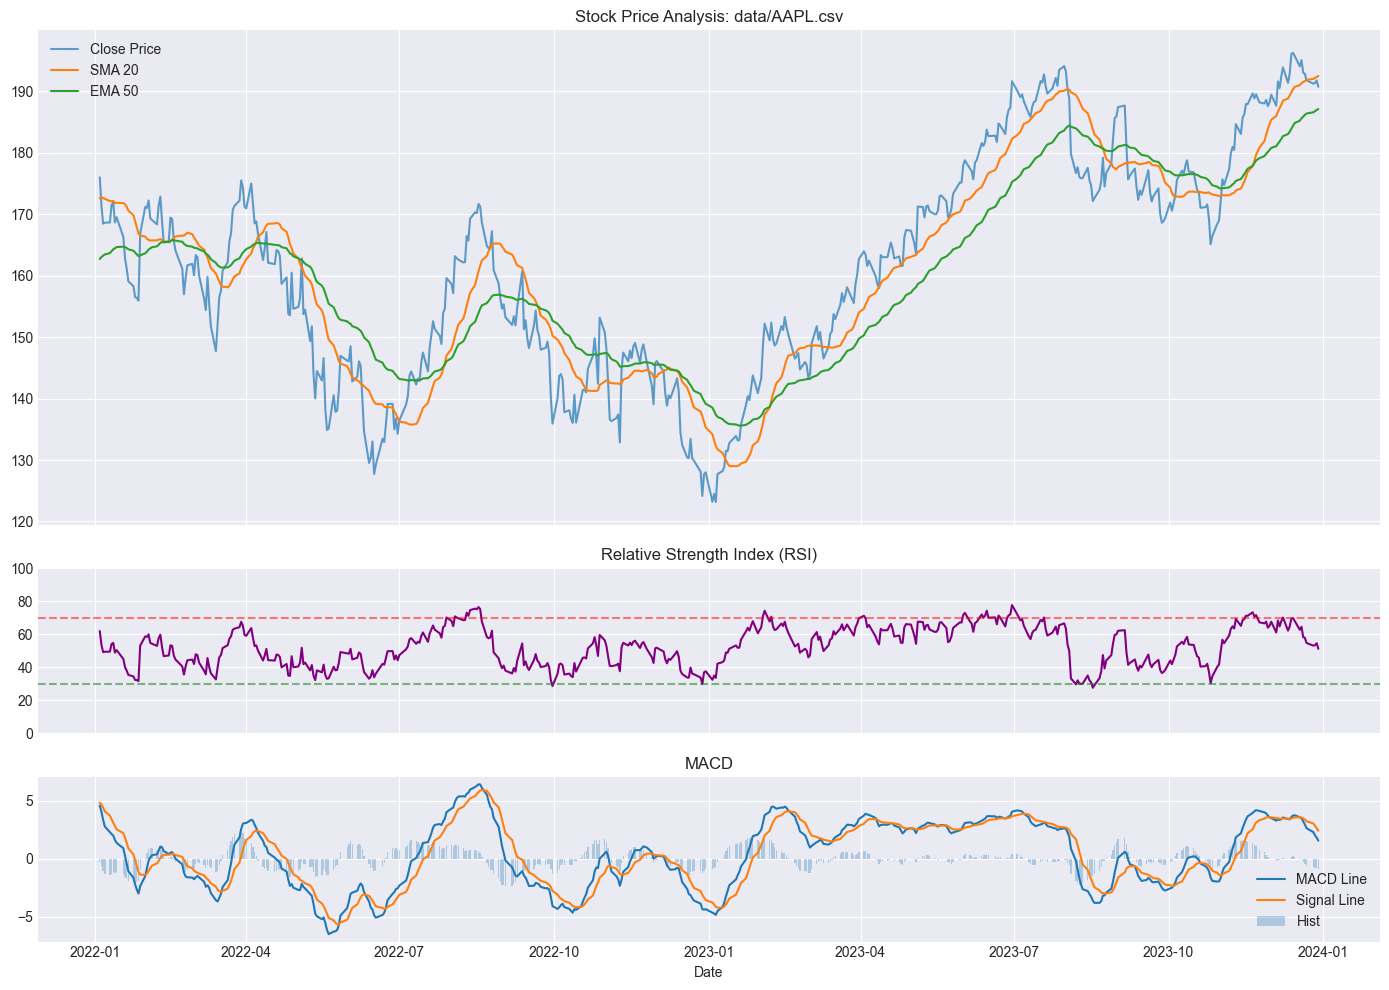

In [13]:


# --- 1. Load and Prepare the Data ---
def load_data(filename):
    """
    Loads data from a CSV file and prepares it for analysis.
    """
    print("Current working directory:", os.getcwd())
    print("Trying to load:", filename)

    try:
        df = pd.read_csv(filename)
        
        # Convert 'Date' to datetime objects
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Set Date as index for time-series analysis
        df.set_index('Date', inplace=True)
        
        # Sort by date to ensure correct calculation of indicators
        df.sort_index(inplace=True)
        
        print(f"Successfully loaded {filename}. Shape: {df.shape}")
        return df

    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None


# ✅ Since the file is inside the folder "data", use this path:
filename = 'data/AAPL.csv'
df = load_data(filename)



# --- 2. Apply Analysis Indicators with TA-Lib ---
if df is not None:
    # A. Moving Averages
    df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
    df['EMA_50'] = talib.EMA(df['Close'], timeperiod=50)

    # B. RSI (Relative Strength Index)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # C. MACD
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(
        df['Close'], fastperiod=12, slowperiod=26, signalperiod=9
    )


# --- 3. Daily Returns + Volatility ---
if df is not None:
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Rolling 20-day annualized volatility
    df['Volatility_20D'] = df['Log_Return'].rolling(20).std() * np.sqrt(252)

    print("Technical indicators and metrics calculated.")
    print(df[['Close', 'SMA_20', 'RSI', 'MACD', 'Volatility_20D']].tail())


# --- 4. Visualize the Data ---
if df is not None:
    # last 500 days for clean chart
    plot_data = df.tail(500)

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, 
                             gridspec_kw={'height_ratios': [3, 1, 1]})
    plt.style.use('seaborn-v0_8-darkgrid')

    # Plot 1: Price + MAs
    axes[0].plot(plot_data.index, plot_data['Close'], label='Close Price', alpha=0.7)
    axes[0].plot(plot_data.index, plot_data['SMA_20'], label='SMA 20')
    axes[0].plot(plot_data.index, plot_data['EMA_50'], label='EMA 50')
    axes[0].set_title(f'Stock Price Analysis: {filename}')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: RSI
    axes[1].plot(plot_data.index, plot_data['RSI'], label='RSI (14)', color='purple')
    axes[1].axhline(70, color='red', linestyle='--', alpha=0.5)
    axes[1].axhline(30, color='green', linestyle='--', alpha=0.5)
    axes[1].set_title('Relative Strength Index (RSI)')
    axes[1].set_ylim(0, 100)
    axes[1].grid(True)

    # Plot 3: MACD
    axes[2].plot(plot_data.index, plot_data['MACD'], label='MACD Line')
    axes[2].plot(plot_data.index, plot_data['MACD_Signal'], label='Signal Line')
    axes[2].bar(plot_data.index, plot_data['MACD_Hist'], label='Hist', alpha=0.3)
    axes[2].set_title('MACD')
    axes[2].legend()
    axes[2].grid(True)

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


In [3]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. Download VADER lexicon (if not already present)
# nltk.download('vader_lexicon')

def get_vader_sentiment(text):
    """Calculates the Compound Sentiment Score using VADER."""
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound'] # Returns score between -1 (Negative) and 1 (Positive)

# news_df['Sentiment_Score'] = news_df['Headline'].apply(get_vader_sentiment)

In [9]:
# -------------------------------------------------------
# SENTIMENT SETUP (No External Libraries Needed)
# -------------------------------------------------------

pos_words = {"good","up","gain","positive","beat","outperform","growth","strong","surge"}
neg_words = {"bad","down","loss","negative","miss","underperform","fall","weak","drop"}

def score_text(t):
    t = str(t).lower()
    score = 0

    for w in pos_words:
        if w in t:
            score += 1
    for w in neg_words:
        if w in t:
            score -= 1

    # Normalize using tanh for softer scaling
    return np.tanh(score)

print("Using simple built-in sentiment analyzer (no libs needed)")


Using simple built-in sentiment analyzer (no libs needed)


In [11]:
import os
print(os.listdir())


['.git', '.github', '.gitignore', '.ipynb_checkpoints', '.venv', '.vscode', '01-Descriptive-EDA.ipynb', 'data', 'nltk_data', 'notebooks', 'README.md', 'requirements.txt', 'scripts', 'src', 'tests']


In [16]:
import os

print(os.listdir("data"))


['AAPL.csv', 'AMZN.csv', 'correlation.ipynb', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv', 'Pynance_demo.ipynb', 'raw_analyst_ratings.csv', 'sentiment_analysis.ipynb', 'Stock_market.ipynb', 'Time_series.ipynb', 'Visualization.ipynb']


In [17]:
# task3_sentiment_correlation.py
# Place this file at the project root (or run from project root).
# It expects:
#   week1/data/AAPL.csv
#   week1/data/raw_analyst_ratings.csv
# and will write:
#   week1/data/sentiment_vs_returns.csv

import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sys

# -----------------------------
# Paths (adjust only if needed)
# -----------------------------
DATA_DIR = Path("week1") / "data"
STOCK_CSV = DATA_DIR / "AAPL.csv"
NEWS_CSV = DATA_DIR / "raw_analyst_ratings.csv"
OUT_CSV = DATA_DIR / "sentiment_vs_returns.csv"

# -----------------------------
# Sentiment scorer with fallbacks
# -----------------------------
def get_sentiment_scorer():
    # Try VADER
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        vader = SentimentIntensityAnalyzer()
        print("Using VADER for sentiment scoring.")
        return lambda txt: vader.polarity_scores(str(txt))["compound"]
    except Exception:
        print("VADER not available — trying TextBlob...")

    # Try TextBlob
    try:
        from textblob import TextBlob
        print("Using TextBlob for sentiment scoring.")
        return lambda txt: TextBlob(str(txt)).sentiment.polarity
    except Exception:
        print("TextBlob not available — using simple keyword fallback (less accurate).")

    # Fallback simple keyword-based scorer
    pos_words = {"good","up","gain","positive","beat","outperform","growth","strong","surge","raise","upgrade"}
    neg_words = {"bad","down","loss","negative","miss","underperform","fall","weak","drop","downgrade"}

    def fallback(txt):
        s = 0
        t = str(txt).lower()
        for w in pos_words:
            if w in t:
                s += 1
        for w in neg_words:
            if w in t:
                s -= 1
        # normalize to -1..1 roughly
        return np.tanh(s)
    return fallback

score_text = get_sentiment_scorer()

# -----------------------------
# Load stock data
# -----------------------------
if not STOCK_CSV.exists():
    print(f"ERROR: stock file not found at {STOCK_CSV}", file=sys.stderr)
    sys.exit(1)

stock = pd.read_csv(STOCK_CSV, parse_dates=["Date"], dayfirst=False)
# Ensure standard columns exist
if "Close" not in stock.columns:
    print(f"ERROR: 'Close' column not found in {STOCK_CSV}. Columns: {stock.columns.tolist()}", file=sys.stderr)
    sys.exit(1)

stock = stock.rename(columns={"Date":"date"}).set_index("date").sort_index()
stock["daily_return"] = stock["Close"].pct_change()

# -----------------------------
# Load news data
# -----------------------------
if not NEWS_CSV.exists():
    print(f"ERROR: news file not found at {NEWS_CSV}", file=sys.stderr)
    sys.exit(1)

# Attempt to infer the timestamp/date column
news_df = pd.read_csv(NEWS_CSV, keep_default_na=False)

# Identify a column that likely contains timestamps/dates
date_col = None
for candidate in ["timestamp","time","datetime","date","published_at","published"]:
    if candidate in news_df.columns:
        date_col = candidate
        break

if date_col is None:
    # If there's no obvious date column, try to find any datetime-like column
    for col in news_df.columns:
        sample = str(news_df[col].dropna().iloc[0]) if len(news_df[col].dropna())>0 else ""
        try:
            pd.to_datetime(sample)
            date_col = col
            break
        except Exception:
            continue

if date_col is None:
    print("ERROR: Could not find a date/timestamp column in news CSV. Columns:", news_df.columns.tolist(), file=sys.stderr)
    sys.exit(1)

# Identify a headline/text column
headline_col = None
for candidate in ["headline","title","text","news","article","summary"]:
    if candidate in news_df.columns:
        headline_col = candidate
        break

if headline_col is None:
    # fallback to first non-date text column
    for col in news_df.columns:
        if col == date_col: 
            continue
        if news_df[col].dtype == object:
            headline_col = col
            break

if headline_col is None:
    print("ERROR: Could not find a headline/text column in news CSV. Columns:", news_df.columns.tolist(), file=sys.stderr)
    sys.exit(1)

# Parse dates
news_df[date_col] = pd.to_datetime(news_df[date_col], errors="coerce")
if news_df[date_col].isna().all():
    print(f"ERROR: All values in detected date column ({date_col}) failed to parse as dates.", file=sys.stderr)
    sys.exit(1)

# Create a normalized calendar date for aggregation
news_df["news_date"] = news_df[date_col].dt.date
news_df["news_date"] = pd.to_datetime(news_df["news_date"])

# Compute sentiment per headline
news_df["sentiment"] = news_df[headline_col].astype(str).apply(score_text)

# Aggregate daily (mean)
daily_sent = news_df.groupby("news_date")["sentiment"].mean().rename("avg_sentiment")
daily_sent.index = pd.to_datetime(daily_sent.index)

# -----------------------------
# Align stock trading dates with news (join)
# -----------------------------
combined = stock[["daily_return"]].join(daily_sent, how="left")
combined["avg_sentiment"] = combined["avg_sentiment"].fillna(0.0)  # neutral if no news that day

# drop first NaN return
combined = combined.dropna(subset=["daily_return"])

# -----------------------------
# Correlation calculations
# -----------------------------
# Same-day correlation
r_same, p_same = pearsonr(combined["avg_sentiment"], combined["daily_return"])
# Next-day (sentiment -> next trading day return)
combined["return_t_plus_1"] = combined["daily_return"].shift(-1)
valid_idx = combined["return_t_plus_1"].notna()
if valid_idx.sum() > 1:
    r_next, p_next = pearsonr(combined.loc[valid_idx, "avg_sentiment"], combined.loc[valid_idx, "return_t_plus_1"])
else:
    r_next, p_next = np.nan, np.nan

# Save output
combined.to_csv(OUT_CSV)

# -----------------------------
# Print results and quick plots
# -----------------------------
print("\n=== Sentiment vs Returns (summary) ===")
print(f"Stock file: {STOCK_CSV}")
print(f"News file:  {NEWS_CSV}")
print(f"Data points (days): {len(combined)}")
print(f"Same-day Pearson r = {r_same:.4f}, p-value = {p_same:.4g}")
print(f"Next-day Pearson r = {r_next if not np.isnan(r_next) else 'NA'} (p = {p_next if not np.isnan(p_next) else 'NA'})")
print(f"Saved combined CSV to: {OUT_CSV}\n")

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(combined["avg_sentiment"], combined["daily_return"], alpha=0.6)
plt.xlabel("Average Daily Sentiment")
plt.ylabel("Daily Return")
plt.title(f"Sentiment vs Daily Returns (same-day r={r_same:.4f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series quick plots (two separate figures)
plt.figure(figsize=(12,3))
plt.plot(combined.index, combined["avg_sentiment"], label="Avg Sentiment")
plt.title("Avg Daily Sentiment (time series)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(combined.index, combined["daily_return"], label="Daily Return")
plt.title("Daily Return (time series)")
plt.legend()
plt.tight_layout()
plt.show()


Using VADER for sentiment scoring.


ERROR: stock file not found at week1\data\AAPL.csv


SystemExit: 1

c:\Users\deres\OneDrive\Desktop\week1\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt

# Load datasets
news = pd.read_csv("data/raw_analyst_ratings.csv")
stock = pd.read_csv("data/AAPL.csv")   # Make sure AAPL.csv exists


In [11]:
news_aapl = news[news['stock'] == "AAPL"].copy()
print("AAPL news rows:", len(news_aapl))


AAPL news rows: 441


In [12]:
# Convert dates
news_aapl['date'] = pd.to_datetime(news_aapl['date'], errors='coerce')
stock['Date'] = pd.to_datetime(stock['Date'], errors='coerce')

# Keep only needed columns
stock = stock[['Date', 'Close']]


In [13]:
def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

news_aapl["sentiment"] = news_aapl["headline"].apply(get_sentiment)


In [14]:
daily_sentiment = news_aapl.groupby(news_aapl['date'].dt.date)['sentiment'].mean()
daily_sentiment = daily_sentiment.reset_index()
daily_sentiment.columns = ["Date", "DailySentiment"]
daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"])


In [15]:
stock['Return'] = stock['Close'].pct_change()


In [16]:
merged = pd.merge(daily_sentiment, stock, on="Date", how="inner")
merged.head()


,Date,DailySentiment,Close,Return
0,2020-06-09,0.088333,83.419868,0.031578
1,2020-06-10,0.166919,85.566071,0.025728


In [17]:
correlation = merged['DailySentiment'].corr(merged['Return'])
print("Correlation between Sentiment and Returns:", correlation)


Correlation between Sentiment and Returns: -1.0


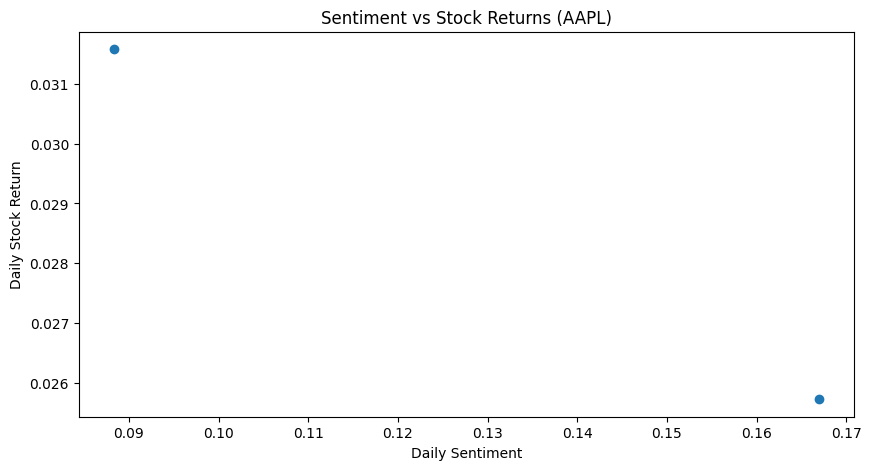

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(merged['DailySentiment'], merged['Return'])
plt.xlabel("Daily Sentiment")
plt.ylabel("Daily Stock Return")
plt.title("Sentiment vs Stock Returns (AAPL)")
plt.show()


In [22]:
import pandas as pd
from textblob import TextBlob

# ------------------------
# Load datasets
# ------------------------
news = pd.read_csv("data/raw_analyst_ratings.csv")
stock = pd.read_csv("data/AAPL.csv")

# ------------------------
# Filter AAPL news only
# ------------------------
news = news[news["stock"] == "AAPL"].copy()

# ------------------------
# Normalize Dates (FINAL FIX)
# ------------------------
news["date"] = pd.to_datetime(news["date"], errors="coerce")

# remove timezone if present
if news["date"].dt.tz is not None:
    news["date"] = news["date"].dt.tz_convert(None)

news["date"] = news["date"].dt.floor("D")

stock["Date"] = pd.to_datetime(stock["Date"], errors="coerce")

# remove timezone if present
if stock["Date"].dt.tz is not None:
    stock["Date"] = stock["Date"].dt.tz_convert(None)

stock["Date"] = stock["Date"].dt.floor("D")

# ------------------------
# Sentiment Analysis
# ------------------------
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news["sentiment"] = news["headline"].apply(get_sentiment)

# ------------------------
# Aggregate Sentiment Per Day
# ------------------------
daily_sentiment = (
    news.groupby("date")["sentiment"]
        .mean()
        .reset_index()
        .rename(columns={"date": "Date", "sentiment": "DailySentiment"})
)

daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"])

# ------------------------
# Stock Daily Returns
# ------------------------
stock["Return"] = stock["Close"].pct_change()

# ------------------------
# Merge Data
# ------------------------
merged = pd.merge(daily_sentiment, stock, on="Date", how="inner")

# ------------------------
# Correlation Analysis
# ------------------------
correlation = merged["DailySentiment"].corr(merged["Return"])

print("\n--- RESULTS ---")
print("Daily rows merged:", len(merged))
print("Correlation:", correlation)

merged.to_csv("task3_merged_output.csv", index=False)



--- RESULTS ---
Daily rows merged: 2
Correlation: -1.0
